In [3]:
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm

In [4]:
sys.path.append('../utils')
from evaluation import *
sys.path.append('../')
from ClassificationParScoreProfile import *
from BinarySegmentation import *
from DynamicProgramming import *
from FLOSS import *
from Pelt import *
from Window import *
from BayesianOnlineChangePointDetection import *
from Fluss import *

<h3>Load Dataset</h3>

In [5]:
path_to_data = '../../datasets/Skoltech_Anomaly_Benchmark'
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


In [6]:
# datasets with anomalies loading
test = [pd.read_csv(file, 
                          sep=';', 
                        #   index_col='datetime', 
                          parse_dates=True).drop('anomaly', axis=1) for file in all_files if 'anomaly-free' not in file]

In [7]:
test[0].head()

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,changepoint
0,2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0
1,2020-03-01 15:44:07,0.082724,0.132378,1.12118,-0.273216,92.0144,22.2577,221.250,76.9806,0.0
2,2020-03-01 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0.0
3,2020-03-01 15:44:09,0.083335,0.132742,1.25962,-0.273216,92.2438,22.2657,230.375,77.0000,0.0
4,2020-03-01 15:44:10,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0.0


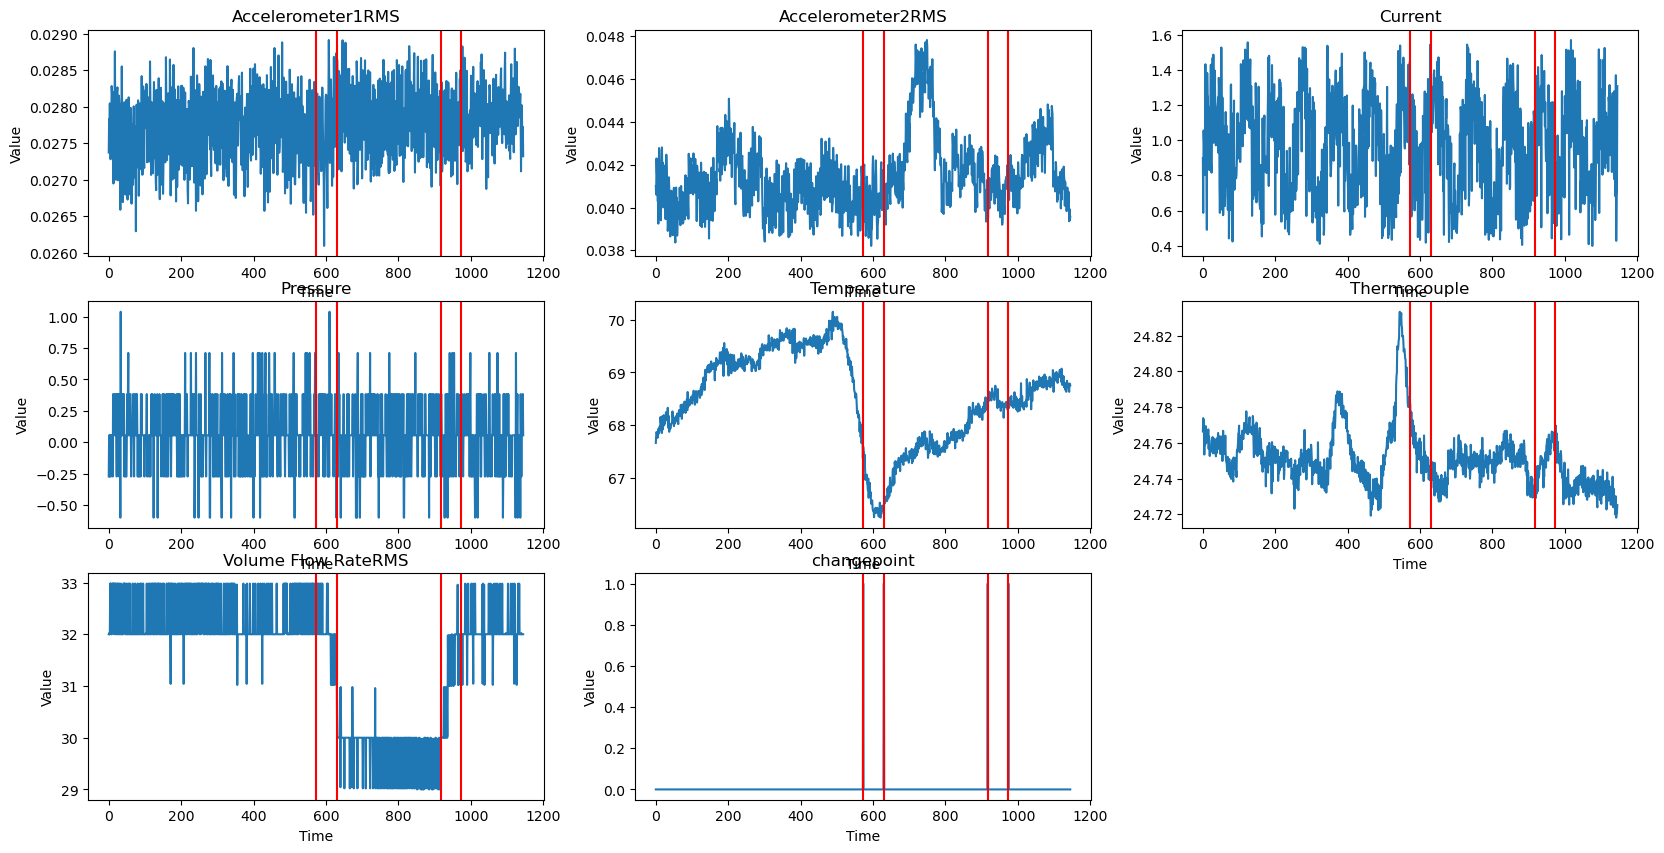

In [8]:
# random dataset visualizing
df=test[16]
df=df.drop(['Voltage',"datetime"],axis=1)
cps=df[df.changepoint==1.0].index
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.plot(df.index,df[df.columns[i]])
    for pt in cps:
        plt.axvline(x=pt,color='r')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(str(df.columns[i]))
    # plt.show()

In [9]:
results={}
def evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,algorithm_name):
    # Initialize lists to store metric values for each time series
    covering_scores = []
    f_measure_scores = []
    nab_scores = []
    i=0
    # Iterate over each time series
    for cps_true,cps_found,ts_len in zip(all_cps_true,all_cps_found,all_ts_len):
        i=i+1
        score_covering = covering({0: cps_true}, cps_found, ts_len)
        covering_scores.append(score_covering)
        
        # Calculate F-measure
        score_F = f_measure({0: cps_true}, cps_found, ts_len) 
        f_measure_scores.append(score_F)
        
        # Format true and predicted change points as Series
        true_cp, predicted_cp = formate_data(cps_true, cps_found,ts_len)
    
        # Evaluate change points using the evaluating_change_point function
        score_NAB = evaluating_change_point(true_cp, predicted_cp, metric='nab')
        nab_scores.append(score_NAB)
        # print(score_NAB)

    # Calculate mean scores across all time series
    mean_covering = sum(covering_scores) / len(covering_scores)
    mean_f_measure = sum(f_measure_scores) / len(f_measure_scores)

    # Calculate mean NAB scores
    nab_scores_filtered = [score for score in nab_scores if not np.isnan(score['Standart']) and not np.isinf(score['Standart'])]
    mean_nab_standard = sum(score['Standart'] for score in nab_scores_filtered) / len(nab_scores_filtered)
    mean_nab_lowFP = sum(score['LowFP'] for score in nab_scores_filtered) / len(nab_scores_filtered)
    mean_nab_lowFN = sum(score['LowFN'] for score in nab_scores_filtered) / len(nab_scores_filtered)


    # Print mean scores
    print(f"Mean Covering: {mean_covering}")
    print(f"Mean F-measure: {mean_f_measure}")
    print(f"Mean NAB (Standard): {mean_nab_standard}")
    print(f"Mean NAB (LowFP): {mean_nab_lowFP}")
    print(f"Mean NAB (LowFN): {mean_nab_lowFN}")

    results[algorithm_name]={"Covering":mean_covering,
                                        "F-measure":mean_f_measure,
                                        "NAB (Standard)":mean_nab_standard,
                                        "NAB (LowFP)":mean_nab_lowFP,
                                        "NAB (LowFN)":mean_nab_lowFN
    }


<h3>BinaryClaSPSegmentation</h3>

In [10]:
all_cps_true=[]
all_cps_found=[]
all_ts_len=[]
# Iterate over each time series
for _,df in tqdm(enumerate(test)):
    ts=df['Accelerometer1RMS'].values
    cps_true=df[df.changepoint==1.0].index
    cps_found = BinaryClaSPSegmentation().fit_predict(ts)
    all_cps_true.append(cps_true)
    all_cps_found.append(cps_found)
    all_ts_len.append(len(ts))

evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,"BinaryClaSPSegmentation")

0it [00:00, ?it/s]

34it [01:34,  2.77s/it]


Mean Covering: 0.465255360990209
Mean F-measure: 0.4426470588235295
Mean NAB (Standard): 7.50764705882353
Mean NAB (LowFP): 6.928823529411765
Mean NAB (LowFN): 7.701470588235293


<h3>DynamicProgramming</h3>

In [11]:
all_cps_true=[]
all_cps_found=[]
all_ts_len=[]
# Iterate over each time series
for _,df in tqdm(enumerate(test)):
    ts=df['Accelerometer1RMS'].values
    cps_true=df[df.changepoint==1.0].index
    cps_found = DynamicProgramming().fit_predict(np.array(ts),len(cps))[:-1]
    all_cps_true.append(cps_true)
    all_cps_found.append(cps_found)
    all_ts_len.append(len(ts))

evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,"DynamicProgramming")


0it [00:00, ?it/s]

34it [02:47,  4.91s/it]


Mean Covering: 0.583857213971692
Mean F-measure: 0.9754901960784315
Mean NAB (Standard): 49.63264705882354
Mean NAB (LowFP): 43.75529411764707
Mean NAB (LowFN): 51.63294117647055


<h3>FLOSS</h3>

In [12]:
all_cps_true=[]
all_cps_found=[]
all_ts_len=[]
# Iterate over each time series
for _,df in tqdm(enumerate(test)):
    ts=df['Accelerometer1RMS'].values
    cps_true=df[df.changepoint==1.0].index
    floss_detector = FLOSS(n_timepoints=len(ts), window_size=20, n_prerun=500, threshold=0.7, excl_factor=5, verbose=0)
    # Update FLOSS with each time point
    for timepoint in ts:
        floss_detector.update(timepoint)

    cps_found = floss_detector.change_points
    all_cps_true.append(cps_true)
    all_cps_found.append(cps_found)
    all_ts_len.append(len(ts))

evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,"FLOSS")



34it [05:10,  9.12s/it]


Mean Covering: 0.5838532029784396
Mean F-measure: 0.864596677831972
Mean NAB (Standard): 50.88294117647057
Mean NAB (LowFP): 45.15529411764706
Mean NAB (LowFN): 53.042058823529416


<h3>Pelt</h3>

In [14]:
all_cps_true=[]
all_cps_found=[]
all_ts_len=[]
# Iterate over each time series
for _,df in tqdm(enumerate(test)):
    ts=df['Accelerometer1RMS'].values
    cps_true=df[df.changepoint==1.0].index
    cps_found = Pelt().fit_predict(np.array(ts),pen=45)[:-1]

    all_cps_true.append(cps_true)
    all_cps_found.append(cps_found)
    all_ts_len.append(len(ts))

evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,"Pelt")

34it [02:21,  4.17s/it]


Mean Covering: 0.36397429653760355
Mean F-measure: 0.34901960784313735
Mean NAB (Standard): 0.0
Mean NAB (LowFP): 0.0
Mean NAB (LowFN): 0.0


<h3>BOCD</h3>

In [15]:
all_cps_true=[]
all_cps_found=[]
all_ts_len=[]
# Iterate over each time series
for _, (ts_name, window_size, cps_true, ts) in tqdm(tssb.iterrows()):
    # Fit the BinaryClaSPSegmentation algorithm and predict change points
    cps_found = bocd(ts,len(cps_true))
    all_cps_true.append(cps_true)
    all_cps_found.append(cps_found)
    all_ts_len.append(ts.shape[0])

evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,"BOCD")
results

34it [00:04,  8.31it/s]


Mean Covering: 0.36397429653760355
Mean F-measure: 0.34901960784313735
Mean NAB (Standard): 0.0
Mean NAB (LowFP): 0.0
Mean NAB (LowFN): 0.0


<h3>Fluss</h3>

In [16]:
all_cps_true=[]
all_cps_found=[]
all_ts_len=[]
# Iterate over each time series
for _,df in tqdm(enumerate(test)):
    ts=df['Accelerometer1RMS'].values
    cps_true=df[df.changepoint==1.0].index
    window_size = 50
    n_cps = len(cps_true)
    # Using fluss function
    cps_found = fluss(ts, window_size, n_cps)

    all_cps_true.append(cps_true)
    all_cps_found.append(cps_found)
    all_ts_len.append(len(ts))

evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,"Fluss")
    

34it [02:16,  4.02s/it]


Mean Covering: 0.5365569832297602
Mean F-measure: 0.7848506069094306
Mean NAB (Standard): 32.61411764705882
Mean NAB (LowFP): 28.00352941176471
Mean NAB (LowFN): 34.32617647058824


In [17]:
# Convert dictionary to DataFrame
results_df = pd.DataFrame(results).T.reset_index()

# Rename the 'index' column to 'name_algo'
results_df = results_df.rename(columns={'index': 'name_algo'})
# save the file
results_df.to_csv('results/Skab.csv', index=False)

print("DataFrame saved as 'Skab.csv'")
# Display the DataFrame
results_df

DataFrame saved as 'Skab.csv'


,name_algo,Covering,F-measure,NAB (Standard),NAB (LowFP),NAB (LowFN)
0,BinaryClaSPSegmentation,0.465255,0.442647,7.507647,6.928824,7.701471
1,DynamicProgramming,0.583857,0.975490,49.632647,43.755294,51.632941
2,FLOSS,0.583853,0.864597,50.882941,45.155294,53.042059
3,Pelt,0.363974,0.349020,0.000000,0.000000,0.000000
4,Window,0.363974,0.349020,0.000000,0.000000,0.000000
5,Fluss,0.536557,0.784851,32.614118,28.003529,34.326176
